In [69]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostRegressor

from xgboost import XGBRegressor
%matplotlib inline 

In [3]:
# There are some Nan values -> substitute them
def detect_NANs(df):
  # detect features with NAN values in a data frame
  features = list(df)
  NAN_features = []
  for feature in features:
    has_NAN = df[[feature]].isna().values.any()
    if has_NAN:
      NAN_features.append(feature)
  return NAN_features

def detect_numeric_categorical_NANs(df, NAN_features):
  categoricals = []
  numericals = []
  for feature in NAN_features:
    if df[feature].dtype == 'object':
      categoricals.append(feature)
    else:
      numericals.append(feature)
  return [numericals, categoricals]


def fill_numeric_NANs(df, features, mean_fill):
  for f in features:
    if mean_fill:
      df[f].fillna(df[f].mean(), inplace=True)

def fill_categorical_NANs(df, features, fill_value):
  for f in features:
    df[f].fillna(fill_value, inplace=True)

def sift_NANs(df, ordinal_mean_fill, categorical_fill_value):
  print(f'------------NAN processing----------------\n')
  NAN_features = detect_NANs(df)
  NAN_features_numeric, NAN_features_categorical = detect_numeric_categorical_NANs(df, NAN_features)
  print(f'{len(NAN_features_numeric)} numeric features with NAN:\n{NAN_features_numeric}\n\n',
      f'{len(NAN_features_categorical)} categorical features with NAN:\n {NAN_features_categorical}\n')
  
  # Step 2: Eliminate NAN values
  fill_numeric_NANs(df, NAN_features_numeric, ordinal_mean_fill)
  fill_categorical_NANs(df, NAN_features_categorical, categorical_fill_value)

  NAN_features = detect_NANs(df)
  print(f'After processing remain {len(NAN_features)} NAN values\n',
        f'------------------------------------------------------')
  return

def get_categorical_features(df, features):
  categoricals = []
  for feature in features:
    if df[feature].dtype == 'object':
      categoricals.append(feature)
  return categoricals

def encode_categoricals(df, categorical_features):
  encoder = LabelEncoder()
  for feature in categorical_features:
    df[feature] = encoder.fit_transform(df[feature].values)


  
def drop_minor_features(df, features_to_drop):
  df_features = df.columns
  for f in features_to_drop:
    if f in df_features:
      df.drop(f, axis=1, inplace=True)
  
def get_insignificant_features(df_correlation, corr_threshold, corr_feature):
  correlations = df_correlation[corr_feature]
  res = []
  for feature in correlations.index:
    if abs(correlations[feature]) < corr_threshold:
      res.append(feature)
  return res

def check_if_features_remained(df_features, features_to_check):
  if any(f in df_features for f in features_to_check):
    return True
  return False

In [105]:
def prepare_dataset(df, 
                     corr_threshold,
                     categorical_fill_value='None',
                     ordinal_mean_fill=True, 
                     features_to_drop=None):
  print(f'-------------------------------------------------\n')

  print(f'STEP1: Look at initial features:\n')
  print(df.info())
  
  print(f'-------------------------------------------------\n')
  
  print(f'STEP3: SIFT NAN VALUES')
  sift_NANs(df, ordinal_mean_fill=True, categorical_fill_value='None')

  print(f'-------------------------------------------------\n')

  print(f'STEP4: ALL CATEGORICAL TO ORDINAL ENCODE\n')
  categorical_features = get_categorical_features(df, list(df))
  print(f'{len(categorical_features)} categorical features, \n{categorical_features}\n')
  encode_categoricals(df, categorical_features)
  categorical_features_after = get_categorical_features(df, list(df))
  print(f'AFTER ENCODING: {len(categorical_features_after)} categorical features, \n{categorical_features_after}')

  print(f'-------------------------------------------------\n')

  print(f'STEP5: HEATMAP TO IDENTIFY LESS SIGNIFICANT FEATURES')
  df_correlation = df_train.corr()
  sns.heatmap(df_correlation)

  print(f'-------------------------------------------------\n')

  print(f'STEP6: REMOVE INSIGNIFICANT FEATURES')

  if features_to_drop is None:
    features_to_drop = get_insignificant_features(df_correlation, corr_threshold, 
                                              corr_feature='SalePrice')
    print(f'{len(features_to_drop)} insignificant features, for level={corr_threshold}\n',
        f'features_to_drop = {features_to_drop}')
  drop_minor_features(df, features_to_drop)

  print(f'-------------------------------------------------\n')

  print(f'STEP7: MAKE SURE NO INSIGNIFICANT FEATURE IS IN DATASET')
  features = df.columns
  check = check_if_features_remained(features, features_to_drop) 
  print(f'If any insignif. features remained? --> {check}')

  print(f'-------------------------------------------------\n')

  print(f'STEP8: Your dataset after processing:')
  print(df.info())

  print(f'-----------------------END-----------------------\n')
  return features_to_drop


def calc_metrics(answers, predictions):
  squares_sum = 0
  for answer, prediction in zip(answers, predictions):
    squares_sum += ((np.log(answer) - np.log(prediction)))**2
  return (squares_sum / (len(answers))) ** (1/2)



def perform_grid_search(
    regressor_name,
    param_grid,
    scoring,
    x_train, y_train,
    x_test, y_test,
    **grid_search_cv_params):
  
  regressor = regressors[regressor_name]
  print(type(regressor))
  print(f'--------------performing grid search--------------\n')
  clf = GridSearchCV(regressor, param_grid, scoring, **grid_search_cv_params)
  clf.fit(x_train, y_train)
  print(f'--------------finished grid search---------------\n\n')

  print(f'--------------------------------------------')
  print(f'The best params are: {clf.best_params_}\n')
  print(f'lets calculate test metrics\n')
  predictions = clf.predict(x_test)
  print(f'The test metrics: {calc_metrics(predictions, y_test)}\n')
  print(f'---------------------END---------------------------\n\n')

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded_test = drive.CreateFile({'id':"1hFI_R74GXe0I6sh8AeCacyAritHN9GUT"})   
downloaded_test.GetContentFile('test.csv')

downloaded_train = drive.CreateFile({'id':"1fYsLA8QtArP_HSlraZU4x0a5IQnRNeN0"})   
downloaded_train.GetContentFile('train.csv')

In [106]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [16]:
df_train.shape, df_test.shape


((1460, 40), (1459, 80))

In [17]:
df_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

-------------------------------------------------

STEP1: Look at initial features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle 

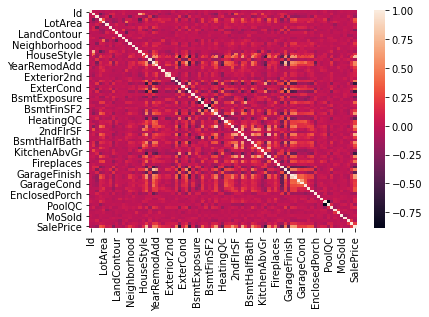

In [107]:
dropped_features = prepare_dataset(df_train, 
                        corr_threshold=0.2)

-------------------------------------------------

STEP1: Look at initial features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1460 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   LotShape       1460 non-null   int64  
 3   Neighborhood   1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   RoofStyle      1460 non-null   int64  
 8   MasVnrArea     1460 non-null   float64
 9   ExterQual      1460 non-null   int64  
 10  Foundation     1460 non-null   int64  
 11  BsmtQual       1460 non-null   int64  
 12  BsmtExposure   1460 non-null   int64  
 13  BsmtFinSF1     1460 non-null   int64  
 14  BsmtUnfSF      1460 non-null   int64  
 15  TotalBsmtSF    1460 non-null   int64  
 16  HeatingQC  

[]

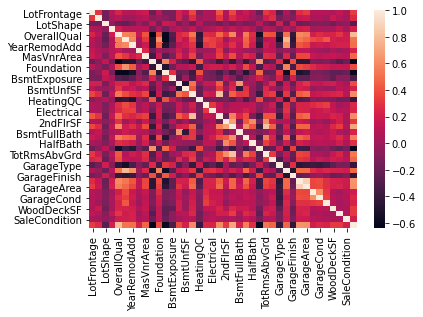

In [9]:
# prepare_dataset(df_test, 
#                 corr_threshold=0.2, 
#                 plot_distrib=False)#,
#                 #features_to_drop = [
#                 #  'Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'
#                 #])

In [20]:
df_train.head()

,LotFrontage,LotArea,LotShape,Neighborhood,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleCondition,SalePrice
0,65.0,8450,3,5,7,2003,2003,1,196.0,2,2,2,3,706,150,856,0,1,5,856,854,1710,1,2,1,2,8,0,1,2003.0,2,2,548,5,5,2,0,61,4,208500
1,80.0,9600,3,24,6,1976,1976,1,0.0,3,1,2,1,978,284,1262,0,1,5,1262,0,1262,0,2,0,3,6,1,1,1976.0,2,2,460,5,5,2,298,0,4,181500
2,68.0,11250,0,5,7,2001,2002,1,162.0,2,2,2,2,486,434,920,0,1,5,920,866,1786,1,2,1,2,6,1,1,2001.0,2,2,608,5,5,2,0,42,4,223500
3,60.0,9550,0,6,7,1915,1970,1,0.0,3,0,4,3,216,540,756,2,1,5,961,756,1717,1,1,0,2,7,1,5,1998.0,3,3,642,5,5,2,0,35,0,140000
4,84.0,14260,0,15,8,2000,2000,1,350.0,2,2,2,0,655,490,1145,0,1,5,1145,1053,2198,1,2,1,2,9,1,1,2000.0,2,3,836,5,5,2,192,84,4,250000


In [21]:
# Step 8 
X_data = df_train.drop('SalePrice', axis=1)
Y_data = df_train['SalePrice']

In [22]:
X_data.shape, Y_data.shape

((1460, 39), (1460,))

In [13]:
# # Step 9 Standardize values
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

ValueError: ignored

In [25]:
# Step 9: Split data
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, random_state = 98987)
print(f'shapes of train and test are {len(x_train)}, {len(x_test)}, {len(y_train)}, {len(y_test)}')

shapes of train and test are 1095, 365, 1095, 365


In [38]:
# Step 10: Prepare scorer, based on our metrics in Kaggle
my_scorer = make_scorer(calc_metrics, greater_is_better=False)

In [70]:
# Step 11: Define regressors
regressors = {
    'random forest': RandomForestRegressor(),
    'XGB': XGBRegressor(),
    'AdaBoost': AdaBoostRegressor()
}

In [64]:
# Step 12: Grid search & Test for RandomForestRegressor

param_grid = {
    'n_estimators': [200, 250, 300],
    'criterion': ['mse', 'mae']
}

perform_grid_search(
    'random forest',
    param_grid,
    my_scorer,
    x_train, y_train,
    x_test, y_test,
    cv=5,
    n_jobs=-1,
    verbose=1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
--------------performing grid search--------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.6min finished


--------------finished grid search---------------


--------------------------------------------
The best params are: {'criterion': 'mse', 'n_estimators': 250}

lets calculate test metrics

The test metrics: 0.1612601098575692

---------------------END---------------------------




In [68]:
# Step 13: Grid search & Test for XGBRegressor

param_grid = {
    'n_estimators': [200, 250, 300, 500],
    'learning_rate': [0.01, 0.1, 0.15],
    'tree_method': ['gpu_hist', 'hist']
}

perform_grid_search(
    'XGB',
    param_grid,
    my_scorer,
    x_train, y_train,
    x_test, y_test,
    cv=5,
    n_jobs=-1,
    verbose=1)

<class 'xgboost.sklearn.XGBRegressor'>
--------------performing grid search--------------

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   23.1s finished


[06:14:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------finished grid search---------------


--------------------------------------------
The best params are: {'learning_rate': 0.1, 'n_estimators': 200, 'tree_method': 'hist'}

lets calculate test metrics

The test metrics: 0.15013073140050004

---------------------END---------------------------




In [71]:
# Step 14: Grid search & Test for AdaBoost Regressor

param_grid = {
    'n_estimators': [200, 250, 300, 500],
    'learning_rate': [0.01, 0.1, 0.15],
    'loss': ['linear', 'square', 'exponential']
}

perform_grid_search(
    'AdaBoost',
    param_grid,
    my_scorer,
    x_train, y_train,
    x_test, y_test,
    cv=5,
    n_jobs=-1,
    verbose=1)

<class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
--------------performing grid search--------------

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.8min finished


--------------finished grid search---------------


--------------------------------------------
The best params are: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}

lets calculate test metrics

The test metrics: 0.20719251510817857

---------------------END---------------------------




-------------------------------------------------

STEP1: Look at initial features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle 

['Id',
 'MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallCond',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'Heating',
 'LowQualFinSF',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Functional',
 'FireplaceQu',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType']

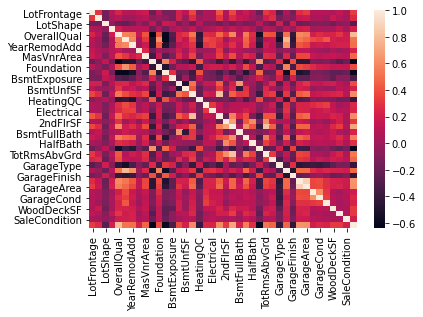

In [109]:
# Data submission
df_test = pd.read_csv('test.csv')
prepare_dataset(df_test, 
                corr_threshold=0.2,
                features_to_drop=dropped_features)


In [110]:
regressor = XGBRegressor(
    learning_rate = 0.1, n_estimators = 200, tree_method = 'hist'
)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
calc_metrics(y_pred, y_test.values)

[07:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.15013073140050004

In [127]:
submit_predictions = regressor.predict(df_test)

In [130]:
Ids = pd.read_csv('test.csv')['Id']
df_submission = pd.DataFrame({
    'Id': Ids,
    'SalePrice': submit_predictions
})
df_submission.head()
df_submission.to_csv('submission.csv', index=False)


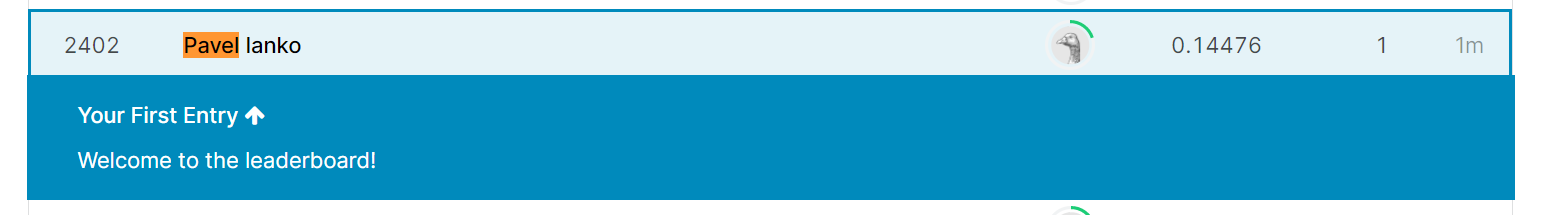